
✅ Processed 3 categories with enough data.

📊 Forecast Results for 'Incident':
ARIMA → RMSE: 127.38, MAE: 127.38, MAPE: nan%
RF    → RMSE: 373.00, MAE: 373.00, MAPE: 6.15%

🔮 Forecasted Ticket Volumes:
ARIMA:         [6196.0]
Random Forest: [6442.0]


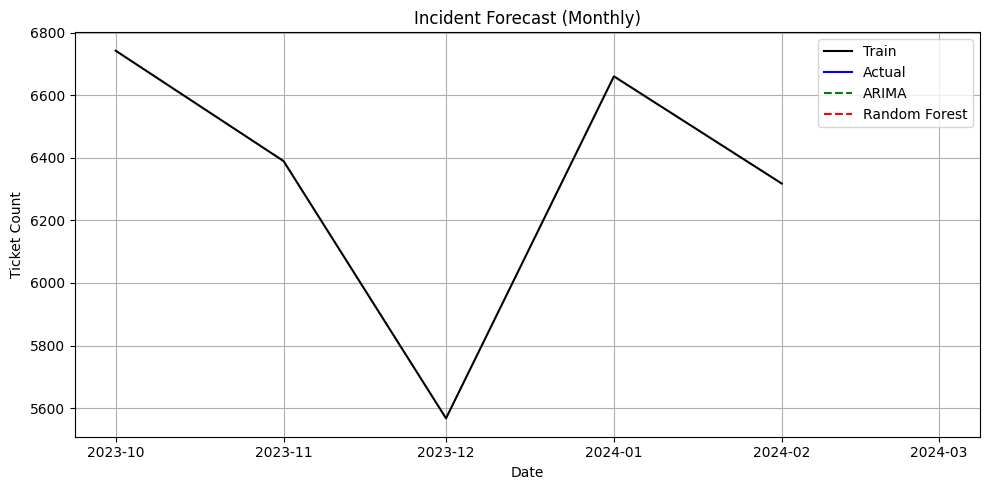

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

# Configuration
TIME_GRANULARITY = 'monthly'  
FORECAST_HORIZON = 1 

# Load data
df = pd.read_csv("ITSM_data.csv", low_memory=False)
df['Close_Time'] = pd.to_datetime(df['Close_Time'], errors='coerce', dayfirst=True)
df.dropna(subset=['Close_Time'], inplace=True)
df['Category'] = df['Category'].astype(str).str.strip().str.title()
df['Date'] = df['Close_Time'].dt.date

# Aggregate ticket count by date and category
daily_counts = df.groupby(['Date', 'Category']).size().reset_index(name='Ticket_Count')

# Preprocess and resample monthly
def preprocess_data(df, time_granularity='monthly'):
    processed_data = {}
    for category in df['Category'].unique():
        cat_df = df[df['Category'] == category].copy()
        cat_df['Date'] = pd.to_datetime(cat_df['Date'])
        cat_df.set_index('Date', inplace=True)
        rule = 'MS' if time_granularity == 'monthly' else 'QS'
        agg_df = cat_df['Ticket_Count'].resample(rule).sum().reset_index()
        agg_df.rename(columns={'Date': 'ds', 'Ticket_Count': 'y'}, inplace=True)
        if len(agg_df) >= FORECAST_HORIZON + 1:
            processed_data[category] = agg_df
    return processed_data

# Metrics
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    y_true_non_zero = np.where(y_true != 0, y_true, np.nan)
    mape = np.nanmean(np.abs((y_true - y_pred) / y_true_non_zero)) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# ARIMA model
def train_and_forecast_arima(train_df, test_df):
    try:
        train_series = train_df.set_index('ds')['y']
        model = ARIMA(train_series, order=(1, 1, 1))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_df))
        return forecast, evaluate_model(test_df['y'], forecast)
    except Exception as e:
        print("ARIMA error:", e)
        return pd.Series([np.nan]*len(test_df), index=test_df['ds']), {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}

# Time features for Random Forest
def create_time_features(df):
    df['year'] = df['ds'].dt.year
    df['month'] = df['ds'].dt.month
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['weekofyear'] = df['ds'].dt.isocalendar().week.astype(int)
    return df

# Random Forest model
def train_and_forecast_rf(train_df, test_df):
    try:
        train_feat = create_time_features(train_df.copy())
        test_feat = create_time_features(test_df.copy())
        features = ['year', 'month', 'dayofyear', 'weekofyear']
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(train_feat[features], train_feat['y'])
        pred = model.predict(test_feat[features])
        return pd.Series(pred, index=test_df['ds']), evaluate_model(test_df['y'], pred)
    except Exception as e:
        print("RF error:", e)
        return pd.Series([np.nan]*len(test_df), index=test_df['ds']), {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}

# Plot results
def plot_forecasts(train_df, test_df, arima_pred, rf_pred, category):
    plt.figure(figsize=(10, 5))
    plt.plot(train_df['ds'], train_df['y'], label='Train', color='black')
    plt.plot(test_df['ds'], test_df['y'], label='Actual', color='blue')
    plt.plot(test_df['ds'], arima_pred, label='ARIMA', linestyle='--', color='green')
    plt.plot(test_df['ds'], rf_pred, label='Random Forest', linestyle='--', color='red')
    plt.title(f"{category} Forecast ({TIME_GRANULARITY.title()})")
    plt.xlabel("Date")
    plt.ylabel("Ticket Count")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run pipeline
processed = preprocess_data(daily_counts, time_granularity=TIME_GRANULARITY)
print(f"\n✅ Processed {len(processed)} categories with enough data.\n")

if not processed:
    print("❌ No valid data available for forecasting.")
else:
    # Run on first valid category (e.g., 'Incident')
    category = list(processed.keys())[0]
    df_agg = processed[category]
    train_df = df_agg.iloc[:-FORECAST_HORIZON]
    test_df = df_agg.iloc[-FORECAST_HORIZON:]

    arima_pred, arima_metrics = train_and_forecast_arima(train_df, test_df)
    rf_pred, rf_metrics = train_and_forecast_rf(train_df, test_df)

    print(f"📊 Forecast Results for '{category}':")
    print(f"ARIMA → RMSE: {arima_metrics['RMSE']:.2f}, MAE: {arima_metrics['MAE']:.2f}, MAPE: {arima_metrics['MAPE']:.2f}%")
    print(f"RF    → RMSE: {rf_metrics['RMSE']:.2f}, MAE: {rf_metrics['MAE']:.2f}, MAPE: {rf_metrics['MAPE']:.2f}%")

    print("\n🔮 Forecasted Ticket Volumes:")
    print("ARIMA:        ", list(arima_pred.round(0)))
    print("Random Forest:", list(rf_pred.round(0)))

    plot_forecasts(train_df, test_df, arima_pred, rf_pred, category)
